# Fine-tuning InternVL-3.5-1B with different PEFT strategies: LoRA/QLoRA/full-tuning on MVBench dataset for classification task

### Installing libraries and conda env

In [ ]:
# !conda create -n internvl python=3.11 -y
# !pip install --index-url https://download.pytorch.org/whl/cu121 \
#   torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1

# !pip install "deepspeed>=0.16.7"

# !pip install transformers==4.43.2 accelerate==0.33.0 bitsandbytes==0.43.1 peft==0.11.1 \
#            datasets==2.19.0 pyarrow==17.0.0 av==12.0.0 decord==0.6.0 \
#            lightning==2.4.0 wandb==0.17.8 timm==1.0.9

# !pip install nltk
# !pip install -q flash_attn
# !pip install opencv-python
# !pip install imageio

# !pip install 'accelerate>=1.1.0'
# !pip install -U bitsandbytes>=0.46.1

Original model on HF: https://huggingface.co/OpenGVLab/InternVL3_5-1B

MVBench: https://huggingface.co/datasets/OpenGVLab/MVBench

Here we want to answer given multiple choice questions based on the video. The questions can be related to temporal aspects of the video, pose prediction and so on.

In [ ]:
import os
import av
import re
import gc
import sys
import json
import random
import bisect
import shutil
import traceback
import numpy as np
from nltk import edit_distance
from pathlib import Path
from copy import deepcopy
from typing import Dict, Any, List, Union, Tuple

from transformers import (AutoConfig, AutoModelForCausalLM, AutoTokenizer,
                          HfArgumentParser, Trainer, TrainingArguments,
                          set_seed, AutoProcessor)
from transformers import BitsAndBytesConfig
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from huggingface_hub import snapshot_download, hf_hub_download
from datasets import load_dataset, concatenate_datasets
from PIL import Image, ImageFile, PngImagePlugin, UnidentifiedImageError

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping, Callback


MAX_LENGTH = 8 * 256 + 1024  # 8 frames * 256 tokens + 1024 text tokens = 3072
MODEL_ID = "OpenGVLab/InternVL3_5-1B"
REPO_ID = "https://huggingface.co/OpenGVLab/InternVL2_5-1B"

from huggingface_hub import login
access_token = "YOUR_ACCESS_TOKEN"
login(access_token)

USE_LORA = False
USE_QLORA = True

In [ ]:
! git clone https://github.com/OpenGVLab/InternVL.git

In [ ]:
! ls InternVL/internvl_chat

In [ ]:
sys.path.append('./InternVL/internvl_chat')

In [ ]:
from internvl.dist_utils import init_dist
from internvl.model.internvl_chat import (InternVisionConfig,
                                          InternVisionModel,
                                          InternVLChatConfig,
                                          InternVLChatModel)
from internvl.train.dataset import (ConcatDataset, read_frames_decord,
                                    WeightedConcatDataset, build_transform,
                                    dynamic_preprocess, preprocess,
                                    preprocess_internlm, preprocess_mpt,
                                    preprocess_phi3,)

from internvl.train.constants import IMG_CONTEXT_TOKEN

In [ ]:
import sys
import torch
import transformers
from internvl.train.dataset import get_conv_template

def preprocess_internlm_fixed(
        template_name,
        sources,
        tokenizer: transformers.PreTrainedTokenizer,
        num_image_token_list: list,
        text_only: bool = False,
        group_by_length: bool = False,
        use_packed_ds: bool = False,
        ds_name: str = None,
        num_image: int = 1
):
    """Fixed version that doesn't mask all labels on tokenization mismatch"""
    conv = get_conv_template(template_name)
    roles = {'human': conv.roles[0], 'gpt': conv.roles[1]}

    conversations = []
    for i, source in enumerate(sources):
        if roles[source[0]['from']] != conv.roles[0]:
            source = source[1:]
        conv.messages = []
        for j, sentence in enumerate(source):
            role = roles[sentence['from']]
            assert role == conv.roles[j % 2], f'{i}'
            sentence['value'] = sentence['value'].strip()
            conv.append_message(role, sentence['value'])
        conversations.append(conv.get_prompt())

    if not text_only:
        new_conversations = []
        for conversation in conversations:
            for i in range(num_image):
                image_tokens = f'{IMG_START_TOKEN}{IMG_CONTEXT_TOKEN * num_image_token_list[i]}{IMG_END_TOKEN}'
                conversation = conversation.replace('<image>', image_tokens, 1)
            new_conversations.append(conversation)
        conversations = new_conversations

    input_ids = tokenizer(
        conversations,
        return_tensors='pt',
        padding=False if group_by_length or use_packed_ds else 'max_length',
        max_length=tokenizer.model_max_length,
        truncation=True,
    ).input_ids
    targets = input_ids.clone()

    for conversation, target in zip(conversations, targets):
        total_len = int(target.ne(tokenizer.pad_token_id).sum())
        cur_len = 1
        target[:cur_len] = IGNORE_TOKEN_ID
        parts = conversation.split(conv.roles[1])
        info = parts[0] + conv.roles[1]
        temp_len = len(tokenizer(info).input_ids) - 1
        target[cur_len: cur_len + temp_len] = IGNORE_TOKEN_ID
        cur_len = cur_len + temp_len

        for index in range(1, len(parts) - 1):
            info = parts[index]
            part1, part2 = info.split(conv.roles[0])
            temp_len = len(tokenizer(part1).input_ids) - 1
            cur_len = cur_len + temp_len
            part = conv.roles[0] + part2 + conv.roles[1]
            temp_len = len(tokenizer(part).input_ids) - 1
            target[cur_len: cur_len + temp_len] = IGNORE_TOKEN_ID
            cur_len = cur_len + temp_len
        last_info = parts[-1]
        temp_len = len(tokenizer(last_info).input_ids) - 1
        cur_len = cur_len + temp_len

        target[cur_len:] = IGNORE_TOKEN_ID

        if cur_len < tokenizer.model_max_length:
            if cur_len != total_len:
                diff = abs(cur_len - total_len)
                if diff > 100:
                    target[:] = IGNORE_TOKEN_ID
                    print(f'Large tokenization mismatch: {cur_len} vs. {total_len}. Dataset: {ds_name}')
                
        sys.stdout.flush()

    return dict(
        input_ids=input_ids,
        labels=targets,
        attention_mask=input_ids.ne(tokenizer.pad_token_id),
    )

import internvl.train.dataset as dataset_module
dataset_module.preprocess_internlm = preprocess_internlm_fixed
print("Patched preprocess_internlm to fix label masking!")


## MVBench benchmark


<!-- ![MVbench1.png](https://huggingface.co/datasets/OpenGVLab/MVBench/resolve/main/assert/generation.png) -->

It consists of the 20 temporal task examples as follows.

![MVbench-structure.png](https://huggingface.co/datasets/OpenGVLab/MVBench/resolve/main/assert/task_example.png)



In [ ]:
data_list = {
    "Action Sequence": ("action_sequence.json", "star/Charades_v1_480/", "video", True), # has start & end
    "Action Prediction": ("action_prediction.json", "star/Charades_v1_480/", "video", True), # has start & end
    "Action Antonym": ("action_antonym.json", "ssv2_video/", "video", False),
    "Fine-grained Action": ("fine_grained_action.json", "Moments_in_Time_Raw/videos/", "video", False),
    "Unexpected Action": ("unexpected_action.json", "FunQA_test/test/", "video", False),
    "Object Existence": ("object_existence.json", "clevrer/video_validation/", "video", False),
    "Object Interaction": ("object_interaction.json", "star/Charades_v1_480/", "video", True), # has start & end
    "Object Shuffle": ("object_shuffle.json", "perception/videos/", "video", False),
    "Moving Direction": ("moving_direction.json", "clevrer/video_validation/", "video", False),
    "Action Localization": ("action_localization.json", "sta/sta_video/", "video", True),  # has start & end
    "Scene Transition": ("scene_transition.json", "scene_qa/video/", "video", False),
    "Action Count": ("action_count.json", "perception/videos/", "video", False),
    "Moving Count": ("moving_count.json", "clevrer/video_validation/", "video", False),
    "Moving Attribute": ("moving_attribute.json", "clevrer/video_validation/", "video", False),
    "State Change": ("state_change.json", "perception/videos/", "video", False),
    "Fine-grained Pose": ("fine_grained_pose.json", "nturgbd/", "video", False),
    "Character Order": ("character_order.json", "perception/videos/", "video", False),
    "Egocentric Navigation": ("egocentric_navigation.json", "vlnqa/", "video", False),
    "Episodic Reasoning": ("episodic_reasoning.json", "tvqa/frames_fps3_hq/", "frame", True),  # has start & end, read frame
    "Counterfactual Inference": ("counterfactual_inference.json", "clevrer/video_validation/", "video", False),
}

data_dir = "dataset"
if not os.path.exists(data_dir):
    os.mkdir("dataset")

In [ ]:
def read_video_pyav(video_path, start, end, n_frames=8):
    container = av.open(video_path)
    video = container.streams.get(0)[0]

    av_timestamps = [
        int(packet.pts * video.time_base) for packet in container.demux(video) if packet.pts is not None
    ]

    av_timestamps.sort()
    start_id = bisect.bisect_left(av_timestamps, start)
    end_id = bisect.bisect_left(av_timestamps, end)

    if end_id  - start_id < 10:
        end_id += 10
        start_id -= 10

    end_id = min(len(av_timestamps) - 1, end_id)
    start_id = max(1, start_id)

    indices = np.linspace(start_id, end_id, n_frames).astype(int)

    frames = []
    container.seek(0)
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_id:
            break
        if i >= start_id and i in indices:
            frames.append(frame)
    assert len(frames) == n_frames, f"Got {len(frames)} frames but should be {n_frames}. Check the indices: {indices};, start_id: {start_id}, end_id: {end_id}. Len of video is {len(av_timestamps)} frames."
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [ ]:
def collate_read_video(example, path):
    clip = read_video_pyav(f'{path}/{example["video"]}', example.get("start", 1), example.get("end", 1e+10))
    example["clip"] = clip
    return example

### Load videos and captions, if already loaded it, just comment this:

In [ ]:
# videos = snapshot_download(repo_id="OpenGVLab/MVBench", allow_patterns="*", repo_type="dataset")
# for zip_file in os.listdir(f"{videos}/video"):
#     if zip_file.endswith(".zip"):
#         shutil.unpack_archive(f"{videos}/video/{zip_file}", f"{videos}/videos_unzipped/")

In [ ]:
data_list

In [ ]:
MY_TASK_NAME = "Action Localization"
annotation_fn, video_dir, video_type, has_clip = data_list.get(MY_TASK_NAME)
print(f"Task: {MY_TASK_NAME}")
print(f"Annotation file: {annotation_fn}")
print(f"Videos are stored in: {video_dir}")
print(f"Videos are represented as: {video_type}")
print(f"Videos are have start/end timestamps: {has_clip}")

annotation_fn_local = hf_hub_download(repo_id="OpenGVLab/MVBench",
                                    filename='json/' + annotation_fn,
                                    repo_type="dataset",
                                    local_dir=data_dir)
videos_zip = hf_hub_download(repo_id="OpenGVLab/MVBench",
                            filename='video/' + video_dir.split("/")[0] + ".zip",
                            repo_type="dataset",
                            local_dir=data_dir)

# Unzip
for zip_file in os.listdir(f"{data_dir}/video"):
    if zip_file.endswith(".zip"):
        print(zip_file)
        shutil.unpack_archive(f"{data_dir}/video/{zip_file}", f"{data_dir}/video/videos_unzipped/")

In [ ]:
ds = load_dataset("json", data_files=annotation_fn_local, split="train")
ds

In [ ]:
ds[0]

In [ ]:
has_missing = False
for sample in ds:
    if not os.path.exists(f"{data_dir}/video/videos_unzipped/{video_dir}/{sample['video']}"):
        print(f"Video `{sample['video']}` does not exists!")
        has_missing = True

In [ ]:
print(f"Dataset length = {len(ds)}")
if has_missing:
    ds = ds.filter(lambda x: os.path.exists(f"{data_dir}/video/videos_unzipped/{video_dir}/{x['video']}"))

print(f"Dataset length = {len(ds)}")

In [ ]:
# Load videos and split them into frames
# ds = ds.map(collate_read_video,
#             batched=False,
#             fn_kwargs={"path": f"{data_dir}/video/videos_unzipped/{video_dir}"})

# Make conversation

def make_conversation(sample):
    id2choice = {0: "A", 1: "B", 2: "C", 3: "D"}
    question, candidates = sample["question"], sample["candidates"]
    answer_i = candidates.index(sample["answer"])
    answer_choice = id2choice[answer_i]

    mult_choice = "\n"
    for i, choice in enumerate(candidates):
        mult_choice += f"{id2choice[i]}. {choice};\n"

    conversations = [
         {'from': 'human', 'value': question + mult_choice + '<video>'},
         {'from': 'gpt', 'value': answer_choice + " " + sample["answer"]}
    ]
    sample['conversations'] = conversations
    return sample

ds = ds.map(make_conversation,
            batched=False)

In [ ]:
from IPython.display import Video, display, Markdown
import os

def visualize_video(sample, base=f'{data_dir}/video/videos_unzipped/{video_dir}/'):
    video_path = os.path.join(base, sample['video'])
    if not os.path.exists(video_path):
        target = os.path.basename(sample['video'])
        for root, _, files in os.walk(base):
            if target in files:
                video_path = os.path.join(root, target)
                break
    display(Video(video_path, embed=True, html_attributes='controls style="max-width:640px;display:block;"'))

    id2choice = {0:"A", 1:"B", 2:"C", 3:"D"}
    answer_letter = id2choice[sample['candidates'].index(sample['answer'])]
    choices_lines = [f"{id2choice[i]}. {c}" for i, c in enumerate(sample['candidates'])]
    md_lines = [
        f"**Question:** {sample['question']}",
        "",
        *choices_lines,
        "",
        f"**Answer:** {answer_letter} {sample['answer']}",
    ]
    display(Markdown("\n".join(md_lines)))

In [ ]:
visualize_video(ds[10])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('OpenGVLab/InternVL3_5-1B', trust_remote_code=True)
tokenizer.padding_side = "right"

tokenizer

### Video Question-Answering Dataset

In [ ]:
class VideoQADataset(Dataset):

    def __init__(
        self,
        template_name,
        raw_data,
        video_data_dir,
        tokenizer,
        ds_name,
        num_image_token,
        image_size=224,
        is_train=True,
        pad2square=False,
        dynamic_image_size=False,
        use_thumbnail=False,
        min_dynamic_patch=1,
        max_dynamic_patch=6,
        min_num_frame=4,
        max_num_frame=12,
        sampling_method='rand',
        repeat_time=1,
        normalize_type='imagenet',
        random_seed=0,
    ):
        super(VideoQADataset, self).__init__()
        self.ds_name = ds_name
        self.tokenizer = tokenizer
        self.template_name = template_name
        self.num_image_token = num_image_token
        print(f'[Dataset] num_image_token: {num_image_token}')
        print(f'[Dataset] dynamic_image_size: {dynamic_image_size}')
        print(f'[Dataset] use_thumbnail: {use_thumbnail}')
        print(f'[Dataset] min_dynamic_patch: {min_dynamic_patch}, max_dynamic_patch: {max_dynamic_patch}')

        self.image_size = image_size
        self.is_train = is_train
        self.pad2square = pad2square
        self.max_num_frame = max_num_frame
        self.min_num_frame = min_num_frame
        self.sampling_method = sampling_method
        self.num_frames = self.max_num_frame
        self.tcs_loader = None
        self.group_by_length = False

        print('Formatting inputs...Skip in lazy mode')

        self.raw_data = raw_data
        self.rng = np.random.default_rng(seed=random_seed)
        self.rng.shuffle(self.raw_data)

        gc.collect()
        self.root = video_data_dir
        self.cached_data_dict = {}
        self.dynamic_image_size = dynamic_image_size
        self.use_thumbnail = use_thumbnail
        self.min_dynamic_patch = min_dynamic_patch
        self.max_dynamic_patch = max_dynamic_patch
        self.normalize_type = normalize_type

        gc.collect()

    def __len__(self):
        return len(self.raw_data)

    def get_preprocess_function(self):
        return preprocess_internlm

    def load_image(self, image_path):
        if self.tcs_loader is not None and 's3://' in image_path:
            return self.tcs_loader(image_path)
        return Image.open(image_path).convert('RGB')

    def get_image_path(self, image_path):
        if image_path.startswith('s3://'):  # for ceph
            image_path = self.root + image_path
        else:  # for local image
            image_path = os.path.join(self.root, image_path)
        return image_path

    def get_transform(self):
        transform = build_transform(is_train=self.is_train, input_size=self.image_size,
                                    pad2square=self.pad2square, normalize_type=self.normalize_type)
        return transform


    def video_get_item(self, data_item):
        transform = self.get_transform()

        if '<video>' not in data_item['conversations'][0]['value']:
            data_item['conversations'][0]['value'] = '<video>\n' + data_item['conversations'][0]['value']

        video_file = data_item['video']
        video_path = os.path.join(self.root, video_file)

        # Load the video frames using tcs_loader
        image_list = read_frames_decord(video_path,
                                        num_frames=self.num_frames,
                                        min_num_frames=self.min_num_frame,  # FIX: передаем min_num_frame!
                                        client=self.tcs_loader,
                                        clip=(data_item.get('start', None),
                                              data_item.get('end', None)))

        special_tokens = '\n'.join(['Frame{}: <image>'.format(i + 1) for i in range(len(image_list))])
        data_item['conversations'][0]['value'] = data_item['conversations'][0]['value'].replace(
            '<video>', special_tokens)

        pixel_values = [transform(image) for image in image_list]
        pixel_values = torch.stack(pixel_values)
        num_patches = pixel_values.size(0)

        preprocess_function = self.get_preprocess_function()

        num_image_tokens = [self.num_image_token] * num_patches
        ret = preprocess_function(self.template_name, [deepcopy(data_item['conversations'])],
                                  self.tokenizer, num_image_tokens, group_by_length=self.group_by_length,
                                  ds_name=self.ds_name, num_image=num_patches)

        ret = dict(
            input_ids=ret['input_ids'][0],
            labels=ret['labels'][0],
            attention_mask=ret['attention_mask'][0],
            pixel_values=pixel_values,
            image_flags=torch.tensor([1] * num_patches, dtype=torch.long)
        )
        return ret

    def pure_text_get_item(self, data_item):
        transform = self.get_transform()
        image = Image.new('RGB', (224, 224), (255, 255, 255))
        images = dynamic_preprocess(image, min_num=self.min_dynamic_patch, max_num=1,
                                    image_size=self.image_size, use_thumbnail=self.use_thumbnail)

        pixel_values = [transform(image) for image in images]
        pixel_values = torch.stack(pixel_values)
        num_patches = pixel_values.size(0)

        assert num_patches == 1, f'The number of patches should be 1, but got {num_patches}.'

        preprocess_function = self.get_preprocess_function()
        ret = preprocess_function(self.template_name, [deepcopy(data_item['conversations'])],
                                  self.tokenizer, [self.num_image_token * num_patches], text_only=True,
                                  group_by_length=self.group_by_length, ds_name=self.ds_name)

        ret = dict(
            input_ids=ret['input_ids'][0],
            labels=ret['labels'][0],
            attention_mask=ret['attention_mask'][0],
            pixel_values=pixel_values,
            image_flags=torch.tensor([0] * num_patches, dtype=torch.long)
        )
        return ret

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        i = i % len(self.raw_data)
        while True:
            try:
                data_item = json.loads(self.raw_data[i])
                if 'image' in data_item and len(data_item['image']) != 0:
                    if type(data_item['image']) == list:
                        ret = self.multi_modal_multi_image_get_item(data_item)
                    else:
                        ret = self.multi_modal_get_item(data_item)
                elif 'video' in data_item and data_item['video'] is not None and data_item['video'] != '':
                    ret = self.video_get_item(data_item)
                else:
                    ret = self.pure_text_get_item(data_item)
                break
            except Exception as e:
                print(e, self.ds_name, flush=True)
                if not isinstance(e, UnidentifiedImageError):
                    traceback.print_exc()
                data_item = json.loads(self.raw_data[i])
                if 'image' in data_item:
                    if type(data_item['image']) == list:
                        images = [self.root + item for item in data_item['image']]
                        print(f'Failed to load image: {images}, the dataset is: {self.ds_name}')
                    else:
                        if data_item['image'].startswith('s3://'):
                            data_path = self.root + data_item['image']
                        else:
                            data_path = os.path.join(self.root, data_item['image'])
                        print(f'Failed to load image: {data_path}, the dataset is: {self.ds_name}')
                elif 'video' in data_item:
                    data_path = os.path.join(self.root, data_item['video'])
                    print(f'Failed to load video: {data_path}, the dataset is: {self.ds_name}')
                i = random.randint(0, len(self.raw_data) - 1)
        return ret

### Data collators

In [ ]:
import torch

def _to_tensor(x, dtype):
    return x if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=dtype)

def _pad_1d(x, max_len, pad_val):
    x = _to_tensor(x, torch.long)[:max_len]
    out = torch.full((max_len,), pad_val, dtype=torch.long)
    out[:x.shape[0]] = x
    return out

def _get_pad_id(proc):
    return getattr(proc, "pad_token_id", None) or getattr(proc, "eos_token_id", None) or 0

def _gather_per_sample(examples, ids_list, img_ctx_id, num_img_token):
    per_pv, per_fl, per_slots = [], [], []
    for ex, ids in zip(examples, ids_list):
        pv, fl = ex.get("pixel_values"), ex.get("image_flags")
        if pv is None:
            per_pv.append(None); per_fl.append(None); per_slots.append(0); continue
        pv = _to_tensor(pv, pv.dtype if isinstance(pv, torch.Tensor) else torch.float32)
        if fl is not None:
            fl = _to_tensor(fl, torch.long).view(-1)
            P = min(pv.size(0), fl.numel())
            pv = pv[:P]; fl = fl[:P]
        else:
            fl = torch.ones(pv.size(0), dtype=torch.long)
        slots = pv.size(0)*num_img_token if img_ctx_id is None else int((ids == img_ctx_id).sum().item())
        per_pv.append(pv); per_fl.append(fl); per_slots.append(slots)
    return per_pv, per_fl, per_slots

def _global_cap(per_pv, per_fl, total_slots, num_img_token):
    allow_total = total_slots // max(1, num_img_token)
    kept_pv, kept_fl = [], []
    still_need = allow_total
    for pv, fl in zip(per_pv, per_fl):
        if pv is None or still_need <= 0: continue
        take = min(still_need, pv.size(0))
        kept_pv.append(pv[:take])
        kept_fl.append(fl[:take].to(torch.bool))
        still_need -= take
    pixel_values = torch.cat(kept_pv, 0) if kept_pv else None
    image_flags  = torch.cat(kept_fl, 0) if kept_fl else None
    if pixel_values is not None and image_flags is None:
        image_flags = torch.ones(pixel_values.size(0), dtype=torch.bool)
    return pixel_values, image_flags

def train_collate_fn(examples):
    pad_id = _get_pad_id(tokenizer)
    num_img_token = int(globals().get("NUM_IMAGE_TOKEN", 1))
    img_ctx_id = globals().get("IMG_CONTEXT_ID", None)
    
    if not hasattr(train_collate_fn, '_debug_done'):
        train_collate_fn._debug_done = True
        if len(examples) > 0 and 'input_ids' in examples[0]:
            sample_ids = examples[0]['input_ids']
            if isinstance(sample_ids, torch.Tensor):
                sample_ids = sample_ids.tolist()
            num_img_ctx = sample_ids.count(img_ctx_id) if img_ctx_id is not None else 0
            print(f"Sample has {num_img_ctx} IMG_CONTEXT tokens")

    lengths = [int(ex["input_ids"].shape[0]) if isinstance(ex["input_ids"], torch.Tensor)
               else len(ex["input_ids"]) for ex in examples]
    max_len = min(MAX_LENGTH, max(lengths))

    ids_list, attn_list, lbl_list = [], [], []
    for ex in examples:
        ids = _pad_1d(ex["input_ids"], max_len, pad_id)
        lbl = _pad_1d(ex["labels"], max_len, -100)
        ids_list.append(ids)
        lbl_list.append(lbl)
        attn_list.append((ids != pad_id).long())

    per_pv, per_fl, per_slots = _gather_per_sample(examples, ids_list, img_ctx_id, num_img_token)
    total_slots = sum(per_slots)
    pixel_values, image_flags = _global_cap(per_pv, per_fl, total_slots, num_img_token)

    if pixel_values is not None:
        assert pixel_values.size(0) * num_img_token <= total_slots
        assert image_flags is not None and image_flags.numel() == pixel_values.size(0)

    return {
        "input_ids": torch.stack(ids_list, 0),
        "attention_mask": torch.stack(attn_list, 0),
        "labels": torch.stack(lbl_list, 0),
        "pixel_values": pixel_values,
        "image_flags": image_flags,
    }

def eval_collate_fn(examples):
    pad_id = _get_pad_id(tokenizer)
    num_img_token = int(globals().get("NUM_IMAGE_TOKEN", 1))
    img_ctx_id = globals().get("IMG_CONTEXT_ID", None)

    lengths = [int(ex["input_ids"].shape[0]) if isinstance(ex["input_ids"], torch.Tensor)
               else len(ex["input_ids"]) for ex in examples]
    max_len = min(MAX_LENGTH, max(lengths))

    ids_list, attn_list, lbl_list = [], [], []
    for ex in examples:
        ids = _pad_1d(ex["input_ids"], max_len, pad_id)
        lbl = _pad_1d(ex.get("labels", ex["input_ids"]), max_len, -100)
        ids_list.append(ids)
        lbl_list.append(lbl)
        attn_list.append((ids != pad_id).long())

    per_pv, per_fl, per_slots = _gather_per_sample(examples, ids_list, img_ctx_id, num_img_token)
    total_slots = sum(per_slots)
    pixel_values, image_flags = _global_cap(per_pv, per_fl, total_slots, num_img_token)

    if pixel_values is not None:
        assert pixel_values.size(0) * num_img_token <= total_slots
        assert image_flags is not None and image_flags.numel() == pixel_values.size(0)

    return {
        "input_ids": torch.stack(ids_list, 0),
        "attention_mask": torch.stack(attn_list, 0),
        "labels": torch.stack(lbl_list, 0),
        "pixel_values": pixel_values,
        "image_flags": image_flags,
    }

### Check how our Video Dataset and collate-fn functions work

In [ ]:
ds[0]['conversations']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

def plot_token_lengths_from_ds(ds, processor=None, tokenizer=None, model_id=MODEL_ID, sample_n=1000):
    tok = tokenizer
    if tok is None and processor is not None:
        tok = getattr(processor, "tokenizer", None)
    if tok is None:
        tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=False)

    n = min(sample_n, len(ds))
    lengths = []
    for i in range(n):
        conv = ds[i]['conversations']
        text = conv[0]['value'] + "\n" + conv[1]['value']
        ids = tok(text, add_special_tokens=True, return_attention_mask=False)['input_ids']
        lengths.append(len(ids))

    lengths = np.array(lengths)
    avg = float(lengths.mean())
    p95 = float(np.percentile(lengths, 95))
    p99 = float(np.percentile(lengths, 99))

    plt.figure(figsize=(6,4))
    plt.hist(lengths, bins=30, alpha=0.75)
    plt.axvline(avg, color='g', ls='--', label=f'avg={avg:.1f}')
    plt.axvline(p95, color='r', ls='--', label=f'p95={p95:.0f}')
    plt.axvline(p99, color='m', ls='--', label=f'p99={p99:.0f}')
    plt.xlabel('tokens'); plt.ylabel('count'); plt.title('Token length (pre-padding)')
    plt.legend(); plt.show()

    print(f"avg={avg:.1f}, p95={p95:.0f}, p99={p99:.0f}")
    print(f"Optimal Avarage count of tokens is: {int(p95)} (or we can use {int(p99)}, for better performance)")

In [ ]:
plot_token_lengths_from_ds(ds, tokenizer=tokenizer)

## Shuffling and Splitting the Dataset


In [ ]:
ds_shuffled = ds.shuffle(seed=42)
splits = ds_shuffled.train_test_split(test_size=0.2, seed=42)

dataset = {"train": splits["train"], "test": splits["test"]}

print("Train and test datasets sizes")
print(f"Train: {len(dataset['train'])}, Test: {len(dataset['test'])}")

In [ ]:
example = dataset['train'][5]
visualize_video(example)

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


example = dataset['train'][10]

video_path = f"{data_dir}/video/videos_unzipped/{video_dir}/{sample['video']}"
clip = read_video_pyav(video_path, example.get('start', 1), example.get('end', 1e+10), n_frames=8)

video = np.array(clip)

print(f"Video shape: {video.shape}")
print(f"Question: {example['question']}")
print(f"Candidates: {example['candidates']}")
print(f"Answer: {example['answer']}")

In [ ]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib as mpl

mpl.rcParams["animation.html"] = "jshtml"

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_jshtml())

In [ ]:
import json

def to_jsonl_list(hf_split):
    return [json.dumps(row) for row in hf_split]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=False, trust_remote_code=True)

video_root = f"{data_dir}/video/videos_unzipped/{video_dir}"
ds_name = "my_video_qa"
template_name = "internlm2-chat"

if 'NUM_IMAGE_TOKEN' not in globals() or NUM_IMAGE_TOKEN == 1:
    NUM_IMAGE_TOKEN = 256 
    print("NUM_IMAGE_TOKEN not set, using default 256")

num_image_token = NUM_IMAGE_TOKEN
print(f"NUM_IMAGE_TOKEN = {NUM_IMAGE_TOKEN}")
print(f"num_image_token = {num_image_token}")

In [ ]:
train_dataset = VideoQADataset(
    template_name = template_name,
    raw_data = to_jsonl_list(dataset["train"]),
    video_data_dir = video_root,
    tokenizer = tokenizer,
    ds_name = ds_name,
    num_image_token = num_image_token,
    image_size = 448,
    is_train = True,
    pad2square = True,
    dynamic_image_size = False,
    use_thumbnail = False,
    min_dynamic_patch = 1,
    max_dynamic_patch = 6,
    min_num_frame = 8,
    max_num_frame = 8,
    sampling_method = "rand",
    repeat_time = 1,
    normalize_type = "imagenet",
    random_seed = 42,
)

eval_dataset = VideoQADataset(
    template_name = template_name,
    raw_data = to_jsonl_list(dataset["test"]),
    video_data_dir = video_root,
    tokenizer = tokenizer,
    ds_name = ds_name + "_eval",
    num_image_token = num_image_token,
    image_size = 448,
    is_train = False,
    pad2square = True,
    dynamic_image_size = False,
    use_thumbnail = False,
    min_dynamic_patch = 1,
    max_dynamic_patch = 6,
    min_num_frame = 8,
    max_num_frame = 8,
    sampling_method = "uniform",
    repeat_time = 1,
    normalize_type = "imagenet",
    random_seed = 42,
)

# Model

## Load model

Here we load InternVL model with 1 billion trainable parameters (as it combines a **Qwen2 1B language model** with a relatively low-parameter vision **InternViT encoder**).

In [ ]:
import torch
from transformers import AutoModel, BitsAndBytesConfig

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32

if USE_QLORA:
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=dtype,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
    )
    model = AutoModel.from_pretrained(
        MODEL_ID,
        trust_remote_code=True,
        torch_dtype=dtype,
        quantization_config=bnb_config,
        low_cpu_mem_usage=True,
        device_map=None,
    )
else:
    model = AutoModel.from_pretrained(
        MODEL_ID,
        trust_remote_code=True,
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
        device_map=None,
    )

if hasattr(model, "config"):
    model.config.use_cache = False
model.train()

Check that out image tokens match with real num image tokens

In [ ]:
import torch

dummy_image = torch.randn(1, 3, 448, 448).to(model.device).to(model.dtype)

with torch.no_grad():
    vit_embeds = model.extract_feature(dummy_image)

real_num_image_token = vit_embeds.shape[1]
print(f"REAL NUM_IMAGE_TOKEN from Vision Encoder:")
print(f"Input: 1 image 448x448")
print(f"Output: {vit_embeds.shape}")
print(f"=> REAL num_image_token = {real_num_image_token}")
print(f"=> EXPECTED num_image_token = {NUM_IMAGE_TOKEN}")

if real_num_image_token != NUM_IMAGE_TOKEN:
    print(f"MISMATCH!")
    print(f"Updating NUM_IMAGE_TOKEN from {NUM_IMAGE_TOKEN} to {real_num_image_token}")
    NUM_IMAGE_TOKEN = real_num_image_token
    num_image_token = real_num_image_token
    print(f"Updated: NUM_IMAGE_TOKEN = {NUM_IMAGE_TOKEN}")


In [ ]:
from internvl.train.constants import IMG_CONTEXT_TOKEN

IMG_CONTEXT_ID = tokenizer.convert_tokens_to_ids(IMG_CONTEXT_TOKEN)
print(f"IMG_CONTEXT_TOKEN: {IMG_CONTEXT_TOKEN}")
print(f"IMG_CONTEXT_ID: {IMG_CONTEXT_ID}")


if IMG_CONTEXT_ID in (None, -1, tokenizer.unk_token_id):
    print(f"IMG_CONTEXT_TOKEN not found in tokenizer, adding it...")
    tokenizer.add_special_tokens({"additional_special_tokens": [IMG_CONTEXT_TOKEN]})
    model.resize_token_embeddings(len(tokenizer))
    IMG_CONTEXT_ID = tokenizer.convert_tokens_to_ids(IMG_CONTEXT_TOKEN)
    print(f"Added IMG_CONTEXT_TOKEN, new IMG_CONTEXT_ID: {IMG_CONTEXT_ID}")

if hasattr(model, 'img_context_token_id'):
    model.img_context_token_id = IMG_CONTEXT_ID
    print(f"Set model.img_context_token_id = {IMG_CONTEXT_ID}")
else:
    print(f"Model doesn't have img_context_token_id attribute.")
    print(f"This will cause RuntimeError during training.")

print(f"\n{'-'*70}")
print(f"SETUP COMPLETE:")
print(f"  IMG_CONTEXT_ID: {IMG_CONTEXT_ID}")
print(f"  model.img_context_token_id: {getattr(model, 'img_context_token_id', 'NOT SET')}")
print(f"{'-'*70}")


In [ ]:
def find_all_linear_names(model):
    # Only for LoRA, QLoRA
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)
    
lora_target_modules = find_all_linear_names(model)
lora_target_modules

But i found some target modules with indexes of layers, that we dont need (model.layers.1.attn... etc)

In [ ]:
lora_target_modules = [
    "q_proj", "k_proj", "v_proj", "o_proj",
    "gate_proj", "up_proj", "down_proj"
] 
print(f"LoRA target modules: {sorted(set(lora_target_modules))}")

### Create LoRA/QLoRA adapter and configure parameters of low-rank approximation

In [ ]:
lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=lora_target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

llm = getattr(model, "language_model", None)
if llm is None:
    raise RuntimeError("Not found module for language_model in InternVLChatModel")

if USE_QLORA:
    llm = prepare_model_for_kbit_training(llm)
    llm = get_peft_model(llm, lora_cfg)
elif USE_LORA:
    for p in llm.parameters():
        p.requires_grad_(False)
    llm = get_peft_model(llm, lora_cfg)

model.language_model = llm

model.train()
print("Model set to train mode after LoRA")

def summarize_trainable_params(m):
    trainable = sum(int(p.numel()) for p in m.parameters() if p.requires_grad)
    total = sum(int(p.numel()) for p in m.parameters())
    pct = 0.0 if total == 0 else (100.0 * trainable / total)
    print(f"Trainable params: {trainable/1e6:.2f}M / {total/1e6:.2f}M ({pct:.2f}%)")
    return trainable, total, pct

trainable, total, pct = summarize_trainable_params(model)

## Define PyTorch Lightning Module for InternVL-3.5 model

We will use for training [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), which abstracts away much of the boilerplate code and provides a structured framework for model training.

In [ ]:
class InternVLModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.save_hyperparameters({k: v for k, v in config.items() if isinstance(v, (int, float, str, bool))})
        self.model = model
        self.processor = processor
        self.lr = config.get("lr", 1e-4)
        self.batch_size = config.get("batch_size", 1)
        
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_step_count = 0

    def _to_batch_dict(self, batch):
        if isinstance(batch, dict):
            return batch
        b = list(batch) + [None] * 5
        input_ids, attention_mask, pixel_values, labels, image_flags = b[:5]
        out = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "pixel_values": pixel_values,
            "labels": labels,
        }
        if image_flags is not None:
            out["image_flags"] = image_flags
        return out

    def forward(self, input_ids, attention_mask=None, pixel_values=None, labels=None, image_flags=None, **extra):
        kwargs = {"input_ids": input_ids}
        if attention_mask is not None: kwargs["attention_mask"] = attention_mask
        if pixel_values is not None: kwargs["pixel_values"] = pixel_values
        if labels is not None: kwargs["labels"] = labels
        if image_flags is not None: kwargs["image_flags"] = image_flags
        extra.pop("inputs_embeds", None); extra.pop("encoder_outputs", None)
        return self.model(**kwargs)

    def training_step(self, batch, batch_idx):
        batch = self._to_batch_dict(batch)
        
        if self.current_epoch == 0 and batch_idx == 0:
            print(f"\n{'-'*70}")
            print(f"TRAINING STEP DEBUG:")
            if batch.get("input_ids") is not None:
                ids = batch['input_ids']
                img_ctx_id = getattr(self.model, 'img_context_token_id', None)
                print(f"input_ids.shape = {ids.shape}")
                print(f"img_context_token_id = {img_ctx_id}")
                if img_ctx_id is not None:
                    num_img_ctx = (ids == img_ctx_id).sum().item()
                    print(f"   Number of IMG_CONTEXT tokens in batch = {num_img_ctx}")
            if batch.get("pixel_values") is not None:
                pv = batch['pixel_values']
                print(f"pixel_values.shape = {pv.shape}")
                print(f"Expected visual tokens = {pv.shape[0] * 256}")
            print(f"{'-'*70}\n")
        
        out = self(**batch)
        loss = out.loss if hasattr(out, "loss") else out[0]
        
        if loss is not None:
            loss_value = loss.detach().cpu().item()
            self.train_loss_history.append({
                'step': self.train_step_count,
                'epoch': self.current_epoch,
                'batch_idx': batch_idx,
                'loss': loss_value
            })
            self.train_step_count += 1
            
            self.log("train_loss_step", loss_value, on_step=True, on_epoch=False, prog_bar=True, 
                     batch_size=self.batch_size, sync_dist=True)
            self.log("train_loss_epoch", loss_value, on_step=False, on_epoch=True, prog_bar=True, 
                     batch_size=self.batch_size, sync_dist=True)
            
            if batch_idx % 10 == 0:
                print(f"Epoch {self.current_epoch} | Step {self.train_step_count} | Batch {batch_idx} | Loss: {loss_value:.4f}")
            
            return loss
        else:
            print(f"training_step returned None loss at batch {batch_idx}")
            return torch.tensor(0.0, device=self.device, requires_grad=True)

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        batch = self._to_batch_dict(batch)
        out = self(**batch)
        loss = out.loss if hasattr(out, "loss") else out[0]
        
        if loss is not None:
            loss_value = loss.detach().cpu().item()
            self.val_loss_history.append({
                'epoch': self.current_epoch,
                'batch_idx': batch_idx,
                'loss': loss_value
            })
            
            self.log("val_loss", loss_value, on_step=False, on_epoch=True, prog_bar=True, 
                     batch_size=self.batch_size, sync_dist=True)
            return loss
        else:
            print(f"validation_step returned None loss at batch {batch_idx}")
            return torch.tensor(0.0, device=self.device, requires_grad=True)
    
    def on_validation_epoch_end(self):
        if self.val_loss_history:
            epoch_val_losses = [x['loss'] for x in self.val_loss_history if x['epoch'] == self.current_epoch]
            if epoch_val_losses:
                avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
                print(f"\n{'-'*70}")
                print(f"EPOCH {self.current_epoch} VALIDATION SUMMARY:")
                print(f"Avg Validation Loss: {avg_val_loss:.4f}")
                print(f"Min Validation Loss: {min(epoch_val_losses):.4f}")
                print(f"Max Validation Loss: {max(epoch_val_losses):.4f}")
                print(f"{'-'*70}\n")
        
    def configure_optimizers(self):
        no_decay_keys = ("bias", "LayerNorm.weight", "layernorm.weight", "norm.weight")
        decay_params, no_decay_params = [], []
        for name, param in self.model.named_parameters():
            if not param.requires_grad:
                continue
            (no_decay_params if any(k in name for k in no_decay_keys) else decay_params).append(param)

        optimizer = torch.optim.AdamW(
            [
                {"params": decay_params, "weight_decay": 0.01},
                {"params": no_decay_params, "weight_decay": 0.0},
            ],
            lr=self.lr,
            betas=(0.9, 0.999),
            eps=1e-8,
        )
        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn,
                          batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(eval_dataset, collate_fn=eval_collate_fn,
                          batch_size=self.batch_size, shuffle=False, num_workers=4)

In [ ]:
config = {
    "max_epochs": 10,
    "check_val_every_n_epoch": 1,
    "gradient_clip_val": 1.0,
    "accumulate_grad_batches": 8,
    "lr": 1e-4,
    "batch_size": 1,
    "num_nodes": 1,
    "warmup_steps": 50,
}

model_module = InternVLModelPLModule(config=config, processor=tokenizer, model=model)
precision = "bf16-mixed" if torch.cuda.is_available() else 32

## Define callbacks

In [ ]:
# !pip install -U 'tensorboardX'

In [ ]:
from huggingface_hub import HfApi
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="InternVL3.5-1B-QLoRA-Finetune-MVBench")

api = HfApi()

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=3, 
    verbose=True,
    mode="min",
    min_delta=0.01
)

print(f"TensorBoard Logger: tb_logs/InternVL3.5-1B-QLoRA-Finetune-MVBench")
print(f"Early Stopping:")
print(f"- Monitor: val_loss")
print(f"- Patience: 3 epoch")
print(f"- Min delta: 0.01")
print(f"- Mode: minimize")

## Train!
 Trainer class supports many more flags. See the [docs](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html#lightning.pytorch.trainer.trainer.Trainer)

In [ ]:
trainer = L.Trainer(
    max_epochs=config["max_epochs"],
    check_val_every_n_epoch=config["check_val_every_n_epoch"],
    gradient_clip_val=config["gradient_clip_val"],
    accumulate_grad_batches=config["accumulate_grad_batches"],
    devices=[1],
    accelerator="gpu", 
    strategy="auto",
    precision=precision,
    logger=logger if "logger" in globals() else None,
    callbacks=[early_stop_callback] if "early_stop_callback" in globals() else None,
    log_every_n_steps=1,
    enable_progress_bar=True,
    enable_model_summary=True,
)

In [ ]:
trainer.fit(model_module)

In [ ]:
print("SAVING LoRA ADAPTERS")

if 'model_module' in globals() and hasattr(model_module, 'model'):
    lora_save_path = '/home/ivanov/InternVL-tune/trained_lora_adapters'
    print(f"\nSave to: {lora_save_path}")
    try:
        llm = model_module.model.language_model
        llm.save_pretrained(lora_save_path)
        print(f"LoRA adapters saved!")
        import os
        if os.path.exists(lora_save_path):
            for file in os.listdir(lora_save_path):
                file_path = os.path.join(lora_save_path, file)
                size_mb = os.path.getsize(file_path) / (1024 * 1024)
                print(f"{file:30s} {size_mb:>8.2f} MB")
    except Exception as e:
        print(f"ERROR.")
else:
    print("\nmodel_module not found")

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir InternVL-tune/tb_logs/InternVL3.5-1B-QLoRA-Finetune-MVBench/version_72

Train loss history: 640 steps
   Initial loss: 3.8201
   Final loss: 0.1543
   Improvement: 3.6658 (96.0%)

Train loss by epochs: 4 epochs
   Epoch 0: 0.6574
   Epoch 1: 0.1885
   Epoch 2: 0.1697
   Epoch 3: 0.1806

Val loss by epochs: 4 epochs
   Epoch 0: 0.3428
   Epoch 1: 0.1894
   Epoch 2: 0.1761
   Epoch 3: 0.1912


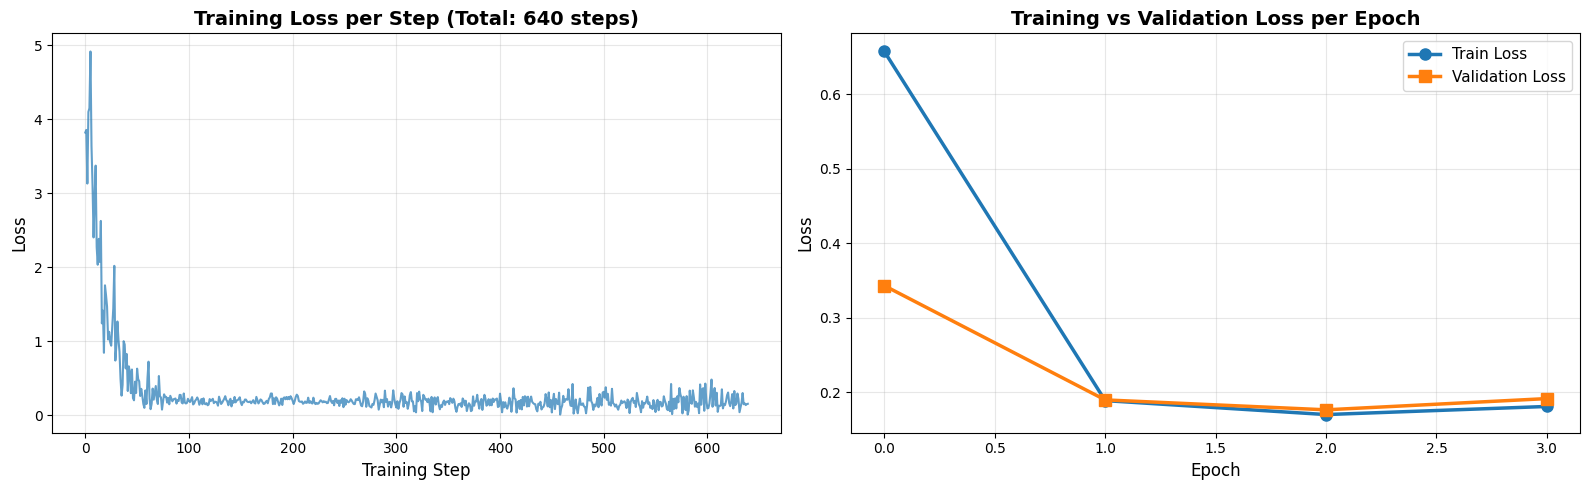


TRAINING RESULTS:
  Final Train Loss (avg):   0.1806
  Final Val Loss (avg):     0.1912
  Total training steps:     640


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_history(model_module):
    if not hasattr(model_module, 'train_loss_history') or not model_module.train_loss_history:
        return
    
    train_history = model_module.train_loss_history
    val_history = model_module.val_loss_history
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    if train_history:
        steps = [x['step'] for x in train_history]
        losses = [x['loss'] for x in train_history]
        
        axes[0].plot(steps, losses, color='#1f77b4', alpha=0.7, linewidth=1.5)
        axes[0].set_xlabel('Training Step', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title(f'Training Loss per Step (Total: {len(steps)} steps)', 
                          fontsize=14, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        print(f"Train loss history: {len(steps)} steps")
        print(f"   Initial loss: {losses[0]:.4f}")
        print(f"   Final loss: {losses[-1]:.4f}")
        print(f"   Improvement: {losses[0] - losses[-1]:.4f} ({(losses[0] - losses[-1])/losses[0]*100:.1f}%)")
    else:
        axes[0].text(0.5, 0.5, 'No train loss data', ha='center', va='center')
        print("No train loss data found")
    
    has_data = False
    
    if train_history:
        epochs = sorted(set(x['epoch'] for x in train_history))
        epoch_train_losses = []
        for epoch in epochs:
            epoch_losses = [x['loss'] for x in train_history if x['epoch'] == epoch]
            epoch_train_losses.append(np.mean(epoch_losses))
        
        axes[1].plot(epochs, epoch_train_losses, 'o-', color='#1f77b4', label='Train Loss', 
                     linewidth=2.5, markersize=8)
        has_data = True
        print(f"\nTrain loss by epochs: {len(epochs)} epochs")
        for i, (epoch, loss) in enumerate(zip(epochs, epoch_train_losses)):
            print(f"   Epoch {epoch}: {loss:.4f}")
    
    if val_history:
        epochs_val = sorted(set(x['epoch'] for x in val_history))
        epoch_val_losses = []
        for epoch in epochs_val:
            epoch_losses = [x['loss'] for x in val_history if x['epoch'] == epoch]
            epoch_val_losses.append(np.mean(epoch_losses))
        
        axes[1].plot(epochs_val, epoch_val_losses, 's-', color='#ff7f0e', label='Validation Loss', 
                     linewidth=2.5, markersize=8)
        has_data = True
        print(f"\nVal loss by epochs: {len(epochs_val)} epochs")
        for i, (epoch, loss) in enumerate(zip(epochs_val, epoch_val_losses)):
            print(f"   Epoch {epoch}: {loss:.4f}")

        if len(epoch_val_losses) > 1:
            if epoch_val_losses[-1] > epoch_val_losses[0]:
                print(f"\n  WARNING: Validation loss increasing!")
                print(f"   First epoch val loss: {epoch_val_losses[0]:.4f}")
                print(f"   Last epoch val loss: {epoch_val_losses[-1]:.4f}")
                print(f"   Increase: {epoch_val_losses[-1] - epoch_val_losses[0]:.4f}")
    
    if has_data:
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].set_title('Training vs Validation Loss per Epoch', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=11, loc='best')
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No epoch loss data', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("TRAINING RESULTS:")
    print("="*70)
    if train_history:
        final_train = [x['loss'] for x in train_history if x['epoch'] == max(x['epoch'] for x in train_history)]
        print(f"  Final Train Loss (avg):   {np.mean(final_train):.4f}")
    if val_history:
        final_val = [x['loss'] for x in val_history if x['epoch'] == max(x['epoch'] for x in val_history)]
        print(f"  Final Val Loss (avg):     {np.mean(final_val):.4f}")
    if train_history:
        print(f"  Total training steps:     {len(train_history)}")
    print("="*70)

plot_loss_history(model_module)


## Inference

In [ ]:
device = "cuda:1"

In [ ]:
import json

test_idx = 2
test_sample = eval_dataset[test_idx]

raw_item_orig = eval_dataset.raw_data[test_idx]

if isinstance(raw_item_orig, str):
    raw_item = json.loads(raw_item_orig)
else:
    raw_item = raw_item_orig

print("DEBUG of dataset")
print("-"*70)
print(f"test_sample (preprocessed) keys: {list(test_sample.keys())}")

for key, value in test_sample.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: {value.shape} (dtype: {value.dtype})")
    else:
        print(f"  {key}: {type(value)}")

print("-"*70)
print(f"raw_item (original data) keys: {list(raw_item.keys())}")

for key in ['image', 'video', 'conversations', 'question_id']:
    if key in raw_item:
        value = raw_item[key]
        if isinstance(value, list):
            print(f"  {key}: list with {len(value)} items")
            if key == 'conversations':
                for i, conv in enumerate(value):
                    print(f"    [{i}] {conv['from']}: {conv['value'][:80]}...")
        else:
            print(f"  {key}: {str(value)[:100]}")


print("-"*70)
print(f"Pixel values info:")
print(f"  Shape: {test_sample['pixel_values'].shape}")
print(f"  {test_sample['pixel_values'].shape[0]} frames loaded")


### Then lets load our fine-tuned model from checkpoint

In [ ]:
from transformers import AutoModel, AutoTokenizer
from peft import PeftModel
import torch
import numpy as np
from PIL import Image
import glob

checkpoint_pattern = '/home/ivanov/InternVL-tune/tb_logs/InternVL3.5-1B-QLoRA-Finetune-MVBench/version_*/checkpoints/*.ckpt'
ckpt_files = sorted(glob.glob(checkpoint_pattern))

if ckpt_files:
    latest_ckpt = ckpt_files[-1]
    print(f"Found {len(ckpt_files)} checkpoints")
    print(f"Latest: {latest_ckpt}")
else:
    latest_ckpt = None
    print(f"No checkpoint found")


if 'model_module' in globals() and hasattr(model_module, 'model'):
    print("\nUsing trained model from memory (model_module)")
    
    inference_model = model_module.model
    inference_model = inference_model.to(device=device)
    
    if hasattr(inference_model, 'language_model'):
        inference_model.language_model = inference_model.language_model.to(dtype=torch.bfloat16)
        print("Language Model converted to bfloat16")
    
    inference_model.eval()
    
elif latest_ckpt is not None:
    print("\nLoading from Lightning checkpoint")
    base_model = AutoModel.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        attn_implementation="eager"
    )
    try:
        checkpoint = torch.load(latest_ckpt, map_location='cpu') 
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
            print(f"Found {len(state_dict)} parameters in checkpoint")
            new_state_dict = {}
            for key, value in state_dict.items():
                new_key = key.replace('model.', '', 1) if key.startswith('model.') else key
                new_state_dict[new_key] = value
            print("Loading weights into model...")
            missing, unexpected = base_model.load_state_dict(new_state_dict, strict=False)
            print(f"Missing keys: {len(missing)}")
            print(f"Unexpected keys: {len(unexpected)}")
            print("Checkpoint loaded")
        else:
            print("No 'state_dict' in checkpoint!")
    except Exception as e:
        print(f"Fatal error loading checkpoint: {e}")
    inference_model = base_model.to(device)
    inference_model.eval()
else:
    print("\nUsing BASE MODEL (NO FINE-TUNING)")
    inference_model = AutoModel.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        attn_implementation="eager"
    ).to(device)
    
    inference_model.eval()

INFO: Minor tokenization mismatch: 2207 vs. 2208 (expected for visual tokens). Dataset: my_video_qa_eval.
Debug: raw_item keys = ['question', 'accurate_start', 'answer', 'end', 'video', 'accurate_end', 'start', 'candidates', 'conversations']

TEST SAMPLE INFO:
----------------------------------------------------------------------
Question: During which part of the video does the action 'person starts closing door' occur?
A. Throughout the entire video.;
B. At the beginning of the video.;
C. At the end of the video.;
D. In the middle of the video.;
<video>
Answer: D In the middle of the video.
Pixel values shape: torch.Size([8, 3, 448, 448])
Number of frames: 8
----------------------------------------------------------------------


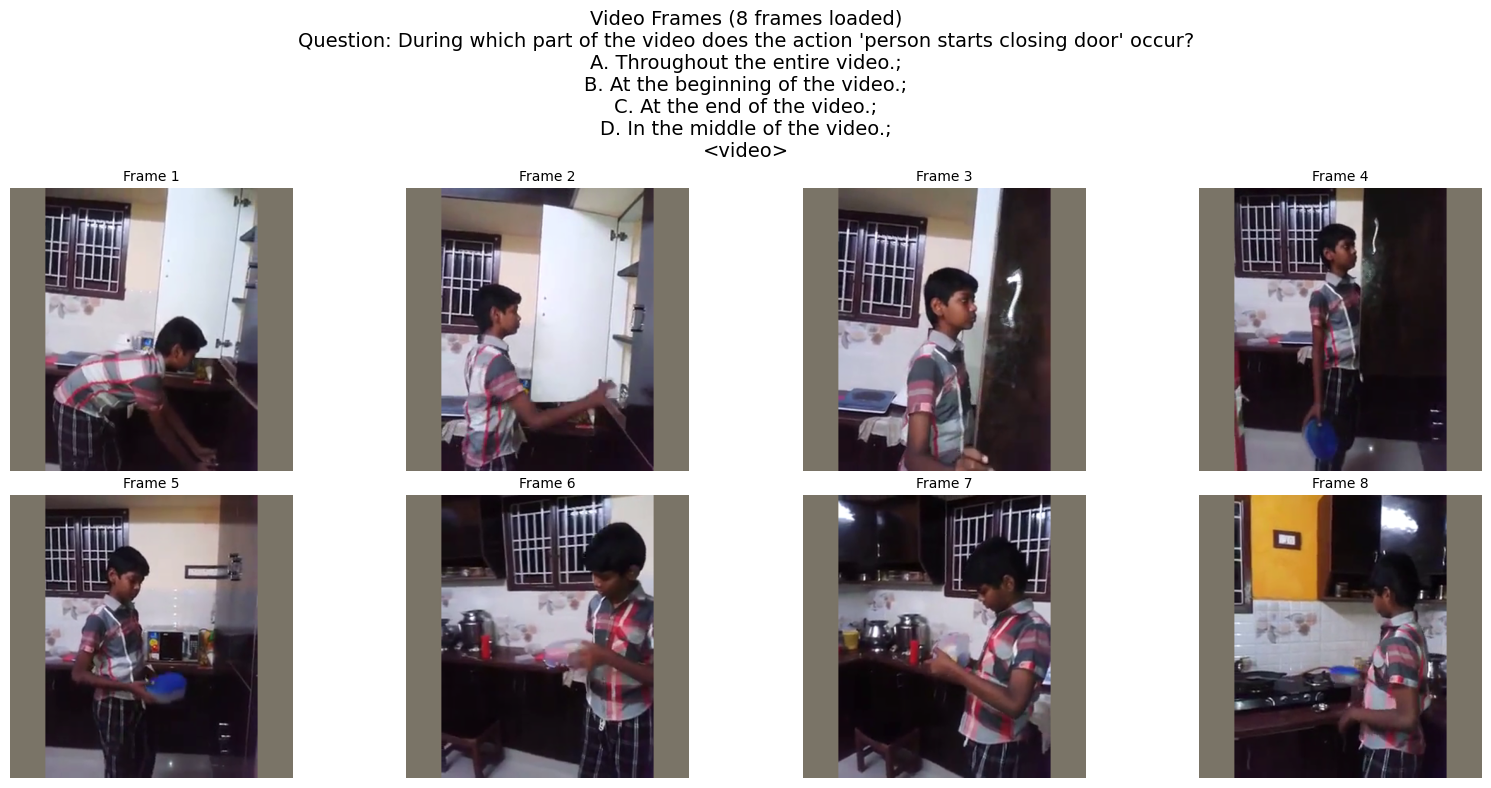

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import json

test_idx = 14
test_sample = eval_dataset[test_idx]

raw_item_orig = eval_dataset.raw_data[test_idx]

if isinstance(raw_item_orig, str):
    raw_item = json.loads(raw_item_orig)
else:
    raw_item = raw_item_orig

conversations = raw_item['conversations']
question = conversations[0]['value']
answer = conversations[1]['value']

print(f"Debug: raw_item keys = {list(raw_item.keys())}")

print("\nTEST SAMPLE INFO:")
print("-"*70)
print(f"Question: {question}")
print(f"Answer: {answer}")
print(f"Pixel values shape: {test_sample['pixel_values'].shape}")
num_frames_actual = test_sample['pixel_values'].shape[0]
print(f"Number of frames: {num_frames_actual}")
if num_frames_actual != 8:
    print(f"WARNING: Got {num_frames_actual} frames instead of 8!")
print("-"*70)


pixel_values = test_sample['pixel_values']
num_frames = pixel_values.shape[0]
frames_to_show = min(8, num_frames)

fig, axarr = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle(f'Video Frames ({num_frames} frames loaded)\nQuestion: {question}', fontsize=14)

for i in range(frames_to_show):
    row = i // 4
    col = i % 4
    
    frame = pixel_values[i].permute(1, 2, 0).cpu().numpy().copy()
    
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
    frame = frame * std + mean
    
    frame = np.clip(frame, 0, 1)
    
    axarr[row, col].imshow(frame)
    axarr[row, col].set_title(f'Frame {i+1}', fontsize=10)
    axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
prompt = question

print(f"INITIAL QUESTION: \n\n{question}...")
print("-"*70)

# Create chat-style prompt
system_prompt = "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
user_message = f"<|im_start|>user\n<image>\n{prompt}<|im_end|>\n"
assistant_start = "<|im_start|>assistant\n"

full_prompt = system_prompt + user_message + assistant_start

print("\nMODIFIED INFERENCE PROMPT:")
print("\n", full_prompt)

input_ids = tokenizer(full_prompt, return_tensors='pt').input_ids.to(device)

IMG_START_TOKEN = '<img>'
IMG_END_TOKEN = '</img>'
IMG_CONTEXT_TOKEN = '<IMG_CONTEXT>'

num_frames = test_sample['pixel_values'].shape[0]
image_tokens = f'{IMG_START_TOKEN}{IMG_CONTEXT_TOKEN * (NUM_IMAGE_TOKEN * num_frames)}{IMG_END_TOKEN}'
full_prompt_with_tokens = full_prompt.replace('<image>', image_tokens)

input_ids = tokenizer(full_prompt_with_tokens, return_tensors='pt').input_ids.to(device)

pixel_values = test_sample['pixel_values'].to(device).to(torch.bfloat16)
image_flags = torch.ones(num_frames, dtype=torch.long).to(device)

In [ ]:
with torch.no_grad():
    outputs = inference_model.generate(
        input_ids=input_ids,
        pixel_values=pixel_values,
        max_new_tokens=100,
        do_sample=False,  # Simple greedy decoding
        num_beams=1,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

generated_ids = outputs[0]
generated_text = tokenizer.decode(generated_ids, skip_special_tokens=False)

assistant_response = generated_text.split('<|im_start|>assistant\n')[-1]
assistant_response = assistant_response.replace('<|im_end|>', '').strip()

print("INFERENCE RESULTS:")
print(f"Question: {question}")
print(f"\nGround Truth: {answer}")
print(f"Model Answer: {assistant_response}")

if answer.lower() in assistant_response.lower():
    print("Result: Correct answer.")
else:
    print("Result: Incorrect answer.")
    
print(f"\nFull generated text (with special tokens):")
print(generated_text)

In [ ]:
import json

def inference_video_qa(model, tokenizer, dataset, idx, device, num_image_token=256):
    model.eval()
    sample = dataset[idx]
    raw_item_orig = dataset.raw_data[idx]
    
    if isinstance(raw_item_orig, str):
        raw_item = json.loads(raw_item_orig)
    else:
        raw_item = raw_item_orig
    
    conversations = raw_item['conversations']
    question = conversations[0]['value']
    ground_truth = conversations[1]['value']
    
    # Combine system prompt for our model
    system_prompt = "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
    user_message = f"<|im_start|>user\n<image>\n{question}<|im_end|>\n"
    assistant_start = "<|im_start|>assistant\n"
    full_prompt = system_prompt + user_message + assistant_start
    
    num_frames = sample['pixel_values'].shape[0]
    image_tokens = f'<img>{"<IMG_CONTEXT>" * (num_image_token * num_frames)}</img>'
    full_prompt_with_tokens = full_prompt.replace('<image>', image_tokens)
    
    input_ids = tokenizer(full_prompt_with_tokens, return_tensors='pt').input_ids.to(device)
    
    pixel_values = sample['pixel_values'].to(device).to(torch.bfloat16)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            pixel_values=pixel_values,
            max_new_tokens=50,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)
    assistant_response = generated_text.split('<|im_start|>assistant\n')[-1]
    assistant_response = assistant_response.replace('<|im_end|>', '').strip()
    
    return assistant_response, ground_truth, question


print("Batch inference on validation set")

num_test_samples = 30
correct = 0
total = 0

predicted_labels = []
true_labels = []

def extract_choice_label(text):
    text = text.strip()
    for char in ['A', 'B', 'C', 'D']:
        if text.upper().startswith(char):
            return char
    for char in ['A', 'B', 'C', 'D']:
        if char in text.upper()[:5]:
            return char
    return None

for i in range(min(num_test_samples, len(eval_dataset))):
    try:
        pred, gt, question = inference_video_qa(
            inference_model, tokenizer, eval_dataset, i, device, NUM_IMAGE_TOKEN
        )
        
        pred_label = extract_choice_label(pred)
        gt_label = extract_choice_label(gt)
        
        if pred_label and gt_label:
            predicted_labels.append(pred_label)
            true_labels.append(gt_label)
        
        is_correct = gt.lower() in pred.lower()
        correct += int(is_correct)
        total += 1
        
        print(f"\nSample {i+1}:")
        print(f"   Question: {question[:80]}...")
        print(f"   Predicted: {pred} [{pred_label}]")
        print(f"   Ground Truth: {gt} [{gt_label}]")
        
    except Exception as e:
        print(f"\nSample {i+1} failed: {e}")

In [ ]:
print(f"FINAL ACCURACY:")
print(f"Correct: {correct}/{total}")
print(f"Accuracy: {100*correct/total:.1f}%")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

if len(predicted_labels) == 0 or len(true_labels) == 0:
    print("\nIt doesn't work.")
else:
    labels = ['A', 'B', 'C', 'D']
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)   
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'},
                ax=axes[0], linewidths=1, linecolor='gray')
    axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='YlOrRd',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Percentage (%)'},
                ax=axes[1], linewidths=1, linecolor='gray')
    axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
  
    print("\nPer-class Accuracy:")

    for i, label in enumerate(labels):
        total_for_class = cm[i, :].sum()
        correct_for_class = cm[i, i]
        if total_for_class > 0:
            acc = correct_for_class / total_for_class * 100
            print(f"   {label}: {correct_for_class}/{total_for_class} = {acc:.1f}%")
        else:
            print(f"   {label}: No samples in validation set")
    
    print("\nMost Common Mistakes:")

    mistakes = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i != j and cm[i, j] > 0:
                mistakes.append((labels[i], labels[j], cm[i, j]))
    
    mistakes.sort(key=lambda x: x[2], reverse=True)
    
    if mistakes:
        for true_label, pred_label, count in mistakes[:5]:  # Top 5 ошибок
            print(f"True: {true_label} -> Predicted: {pred_label} | {count} times")
    else:
        print("Good.")
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, 
                                target_names=labels, 
                                zero_division=0))
    
    print("\nINSIGHTS:")
    
    diagonal_sum = np.trace(cm)
    total_predictions = cm.sum()
    overall_acc = diagonal_sum / total_predictions * 100
    
    print(f"Overall Accuracy: {overall_acc:.1f}%")
    print(f"Total Predictions: {total_predictions}")
    print(f"Correct Predictions: {diagonal_sum}")
    print(f"Wrong Predictions: {total_predictions - diagonal_sum}")
    
    pred_counts = [predicted_labels.count(label) for label in labels]
    true_counts = [true_labels.count(label) for label in labels]
    
    print(f"\nLabel Distribution:")
    for i, label in enumerate(labels):
        print(f"{label}: True={true_counts[i]:2d} | Predicted={pred_counts[i]:2d}")
    
    most_predicted = labels[np.argmax(pred_counts)]
    most_predicted_count = max(pred_counts)
    if most_predicted_count > total_predictions * 0.4:
        print(f"\nModel has BIAS towards label '{most_predicted}'")
        print(f"Predicted '{most_predicted}' {most_predicted_count}/{total_predictions} times ({most_predicted_count/total_predictions*100:.1f}%)")
